In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../..')

In [2]:
import os

from hydra import compose, initialize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")
from scipy.sparse import coo_matrix, save_npz

from src.preprocessing import ClassicDataset
from src.utils.metrics import run_all_metrics, coverage
from src.utils.processing import data_split

In [3]:
with initialize(config_path='../../config/dataset', version_base=None):
    cfg_data = compose(config_name='netflix')

#### Load data

In [4]:
ratings = pd.read_csv(os.path.join(cfg_data['data_src'], cfg_data['ratings_file']))

In [5]:
# nubmer of unique user Ids:
print("Number of unique users:", ratings.userId.nunique())

# nubmer of unique user Ids:
print("Number of unique movies:", ratings.movieId.nunique())

Number of unique users: 480189
Number of unique movies: 17770


In [6]:
print("Preprocess data with the following parameters:")
print("- Minimum item ratings: ", cfg_data['min_item_ratings'])
print("- Minimum user ratings: ", cfg_data['min_user_ratings'])
print("- Positive threshold: ", cfg_data['positive_threshold'])

Preprocess data with the following parameters:
- Minimum item ratings:  100
- Minimum user ratings:  40
- Positive threshold:  3.5


In [7]:
ds = ClassicDataset(ratings)
ds.prepare(cfg_data)
ratings = ds.prepared_data

In [8]:
# nubmer of unique user Ids:
print("Number of unique users after preprocessing:", ratings.userId.nunique())

# nubmer of unique user Ids:
print("Number of unique movies after preprocessing:", ratings.movieId.nunique())

Number of unique users after preprocessing: 284932
Number of unique movies after preprocessing: 11587


In [9]:
# Extract some parameters
user_col = cfg_data["user_column"]
item_col = cfg_data["item_column"]
rating_col = cfg_data["rating_column"]
date_col = cfg_data["date_column"]
weighted = cfg_data["weighted"]

splitting_conf = cfg_data["splitting"]
train_size = splitting_conf["train_size"]
val_size = splitting_conf["val_size"]
test_size = splitting_conf["test_size"]

### 80/10/10 Train/val/test split based on timestapm of all dataset

In [10]:
# Temporal splitting
ratings.sort_values(date_col, inplace=True)
date_at_val_percentile = ratings[date_col].quantile(1 - val_size - test_size)
date_at_test_percentile = ratings[date_col].quantile(1 - test_size)

train_set = ratings[ratings[date_col] <= date_at_val_percentile]
val_set = ratings[
    (ratings[date_col] > date_at_val_percentile)
    & (ratings[date_col] <= date_at_test_percentile)
]
test_set = ratings[ratings[date_col] > date_at_test_percentile]

# Display the three DataFrames
print("DataFrame with 80% percentile:")
print(train_set.shape)

print("DataFrame with 10% percentile:")
print(val_set.shape)

print("DataFrame with last 10% percentile:")
print(test_set.shape)

DataFrame with 80% percentile:
(42363273, 5)
DataFrame with 10% percentile:
(5338121, 5)
DataFrame with last 10% percentile:
(5242784, 5)


In [11]:
# Calculate the number of unique user ratings in the initial dataset
total_unique_ratings = ratings[user_col].nunique()

# Calculate the number of unique user ratings in the df_80_percentile DataFrame
unique_train_set = train_set[user_col].nunique()
fraction_train_set = unique_train_set / total_unique_ratings

# Calculate the number of unique user ratings in the df_10_percentile DataFrame
unique_dev_set = val_set[user_col].nunique()
fraction_dev_set = unique_dev_set / total_unique_ratings

# Calculate the number of unique user ratings in the df_last_10_percentile DataFrame
unique_test_set = test_set[user_col].nunique()
fraction_test_set = unique_test_set / total_unique_ratings

# Display the fractions
print("Fraction of unique users in train_set: {:.2f}".format(fraction_train_set))
print("Fraction of unique users in val_set: {:.2f}".format(fraction_dev_set))
print("Fraction of unique users in test_set: {:.2f}".format(fraction_test_set))

Fraction of unique users in train_set: 0.89
Fraction of unique users in val_set: 0.67
Fraction of unique users in test_set: 0.65


In [12]:
# Get the set of unique user IDs in train_set, dev_set, test_set
original_set = set(ratings[user_col].unique())
users_train_set = set(train_set[user_col].unique())
users_val_set = set(val_set[user_col].unique())
users_test_set = set(test_set[user_col].unique())

# Calculate the set difference between users_dev_set, users_test_set and users_train_set
users_only_in_val_set = users_val_set - users_train_set
users_only_in_test_set = users_test_set - users_train_set

# Calculate the fraction of users in users_dev_set, users_test_set but not in users_train_set
fraction_users_only_in_val_set = len(users_only_in_val_set) / len(users_val_set)
fraction_users_only_in_test_set = len(users_only_in_test_set) / len(users_test_set)

# Display the fraction
print("Fraction of Cold Users val set: {:.2f}".format(fraction_users_only_in_val_set))
print("Fraction of Cold Users test set: {:.2f}".format(fraction_users_only_in_test_set))

Fraction of Cold Users val set: 0.11
Fraction of Cold Users test set: 0.15


In [13]:
# Get the set of unique user IDs in train_set, dev_set, test_set
original_set = set(ratings[item_col].unique())
items_train_set = set(train_set[item_col].unique())
items_val_set = set(val_set[item_col].unique())
items_test_set = set(test_set[item_col].unique())

# Calculate the set difference between users_dev_set, users_test_set and users_train_set
items_only_in_val_set = items_val_set - items_train_set
items_only_in_test_set = items_test_set - items_train_set

# Calculate the fraction of users in users_dev_set, users_test_set but not in users_train_set
fraction_items_only_in_val_set = len(items_only_in_val_set) / len(items_val_set)
fraction_items_only_in_test_set = len(items_only_in_test_set) / len(items_test_set)

# Display the fraction
print("Fraction of Cold Items val set: {:.2f}".format(fraction_items_only_in_val_set))
print("Fraction of Cold Items test set: {:.2f}".format(fraction_items_only_in_test_set))

Fraction of Cold Items val set: 0.01
Fraction of Cold Items test set: 0.01


In [14]:
# Filter out rows in test set that have users, items not present in train and val sets
train_users = set(train_set[user_col])
train_items = set(train_set[item_col])
val_set = val_set[
    val_set[user_col].isin(train_users) & val_set[item_col].isin(train_items)
]
test_set = test_set[
    test_set[user_col].isin(train_users) & test_set[item_col].isin(train_items)
]

In [15]:
print("Percentage of initial data in filtered val set: {:.2f} %".format(val_set.shape[0] / ratings.shape[0] * 100))
print("Percentage of initial data in filtered test set: {:.2f} %".format(test_set.shape[0] / ratings.shape[0] * 100))

Percentage of initial data in filtered val set: 6.26 %
Percentage of initial data in filtered test set: 5.35 %


#### Resulting Rates distribution in train/val/test sets

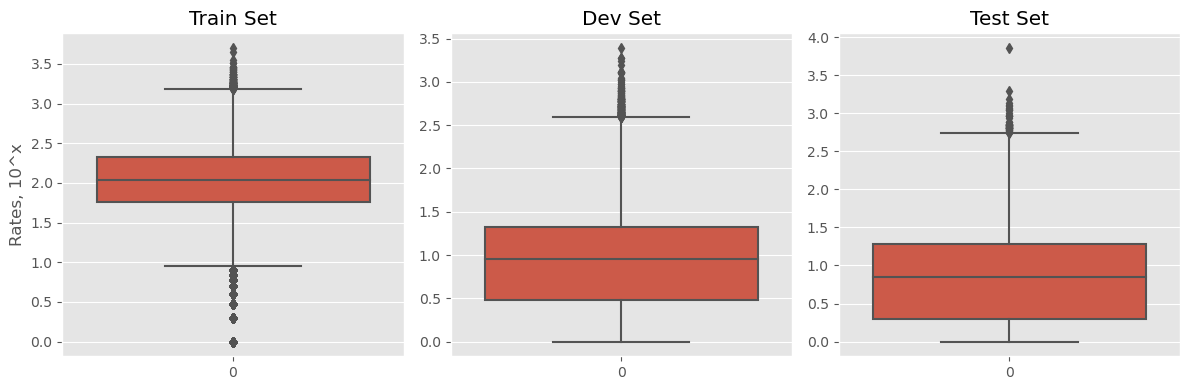

In [16]:
# Create a figure and subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot for the test set
sns.boxplot(data=np.log10(train_set[user_col].value_counts()).values, ax=axs[0])
axs[0].set_ylabel("Rates, 10^x")
axs[0].set_title("Train Set")

# Plot for the dev set
sns.boxplot(data=np.log10(val_set[user_col].value_counts()).values, ax=axs[1])
axs[1].set_title("Dev Set")

# Plot for the train set
sns.boxplot(data=np.log10(test_set[user_col].value_counts()).values, ax=axs[2])
axs[2].set_title("Test Set")

plt.tight_layout()
plt.show()

## 80/10/10 Train/dev/test random split

In [17]:
random_state = np.random.RandomState()
random_index = random_state.random_sample(len(ratings))
train_index = random_index < train_size
val_index = (train_size <= random_index) & (
    random_index < train_size + val_size
)
test_index = random_index >= train_size + val_size

train_set = ratings[train_index]
val_set = ratings[val_index]
test_set = ratings[test_index]

In [18]:
# Calculate the number of unique user ratings in the initial dataset
total_unique_ratings = ratings[user_col].nunique()

# Calculate the number of unique user ratings in the df_80_percentile DataFrame
unique_train_set = train_set[user_col].nunique()
fraction_train_set = unique_train_set / total_unique_ratings

# Calculate the number of unique user ratings in the df_10_percentile DataFrame
unique_dev_set = val_set[user_col].nunique()
fraction_dev_set = unique_dev_set / total_unique_ratings

# Calculate the number of unique user ratings in the df_last_10_percentile DataFrame
unique_test_set = test_set[user_col].nunique()
fraction_test_set = unique_test_set / total_unique_ratings

# Display the fractions
print("Fraction of unique users in train_set: {:.2f}".format(fraction_train_set))
print("Fraction of unique users in val_set: {:.2f}".format(fraction_dev_set))
print("Fraction of unique users in test_set: {:.2f}".format(fraction_test_set))

Fraction of unique users in train_set: 1.00
Fraction of unique users in val_set: 1.00
Fraction of unique users in test_set: 1.00


In [19]:
# Get the set of unique user IDs in train_set, dev_set, test_set
original_set = set(ratings[user_col].unique())
users_train_set = set(train_set[user_col].unique())
users_val_set = set(val_set[user_col].unique())
users_test_set = set(test_set[user_col].unique())

# Calculate the set difference between users_dev_set, users_test_set and users_train_set
users_only_in_val_set = users_val_set - users_train_set
users_only_in_test_set = users_test_set - users_train_set

# Calculate the fraction of users in users_dev_set, users_test_set but not in users_train_set
fraction_users_only_in_val_set = len(users_only_in_val_set) / len(users_val_set)
fraction_users_only_in_test_set = len(users_only_in_test_set) / len(users_test_set)

# Display the fraction
print("Fraction of Cold Users val set: {:.2f}".format(fraction_users_only_in_val_set))
print("Fraction of Cold Users test set: {:.2f}".format(fraction_users_only_in_test_set))

Fraction of Cold Users val set: 0.00
Fraction of Cold Users test set: 0.00


In [20]:
# Get the set of unique user IDs in train_set, dev_set, test_set
original_set = set(ratings[item_col].unique())
items_train_set = set(train_set[item_col].unique())
items_val_set = set(val_set[item_col].unique())
items_test_set = set(test_set[item_col].unique())

# Calculate the set difference between users_dev_set, users_test_set and users_train_set
items_only_in_val_set = items_val_set - items_train_set
items_only_in_test_set = items_test_set - items_train_set

# Calculate the fraction of users in users_dev_set, users_test_set but not in users_train_set
fraction_items_only_in_val_set = len(items_only_in_val_set) / len(items_val_set)
fraction_items_only_in_test_set = len(items_only_in_test_set) / len(items_test_set)

# Display the fraction
print("Fraction of Cold Items val set: {:.2f}".format(fraction_items_only_in_val_set))
print("Fraction of Cold Items test set: {:.2f}".format(fraction_items_only_in_test_set))

Fraction of Cold Items val set: 0.00
Fraction of Cold Items test set: 0.00


In [21]:
# Filter out rows in test set that have users, items not present in train and val sets
train_users = set(train_set[user_col])
train_items = set(train_set[item_col])
val_set = val_set[
    val_set[user_col].isin(train_users) & val_set[item_col].isin(train_items)
]
test_set = test_set[
    test_set[user_col].isin(train_users) & test_set[item_col].isin(train_items)
]

In [22]:
print("Percentage of initial data in filtered val set: {:.2f} %".format(val_set.shape[0] / ratings.shape[0] * 100))
print("Percentage of initial data in filtered test set: {:.2f} %".format(test_set.shape[0] / ratings.shape[0] * 100))

Percentage of initial data in filtered val set: 10.01 %
Percentage of initial data in filtered test set: 10.01 %


#### Resulting Rates distribution in train/val/test sets

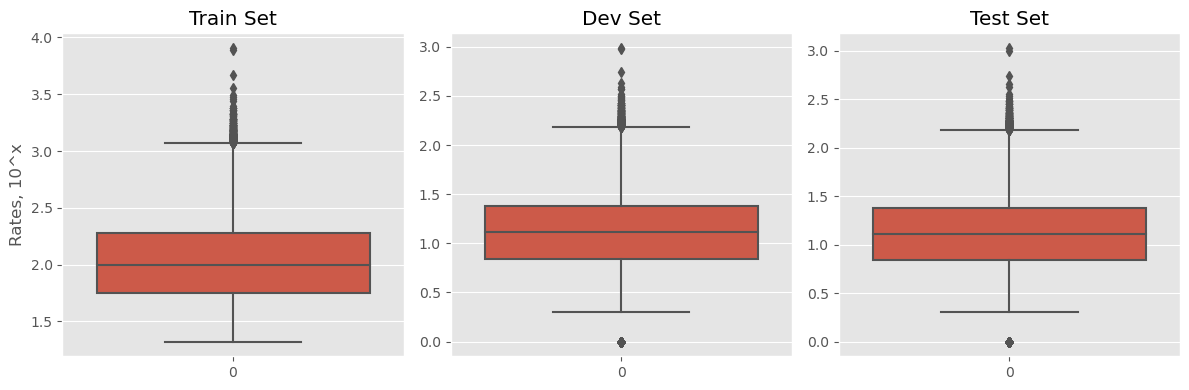

In [23]:
# Create a figure and subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot for the test set
sns.boxplot(data=np.log10(train_set[user_col].value_counts()).values, ax=axs[0])
axs[0].set_ylabel("Rates, 10^x")
axs[0].set_title("Train Set")

# Plot for the dev set
sns.boxplot(data=np.log10(val_set[user_col].value_counts()).values, ax=axs[1])
axs[1].set_title("Dev Set")

# Plot for the train set
sns.boxplot(data=np.log10(test_set[user_col].value_counts()).values, ax=axs[2])
axs[2].set_title("Test Set")

plt.tight_layout()
plt.show()